# Kaggle Competition - New York Stock Exchange 
### One day ahead prediction - Predict next day's stock exchange price

### File Descriptions : 
<b>prices.csv:</b> raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that. <br>
<b>prices-split-adjusted.csv:</b> same as prices, but there have been added adjustments for splits.

### Features: 
<b>Date:</b> Dates from 2010 to 2016  <br>
<b>Symbol:</b> Unique Symbol name of each company <br>
<b>Open:</b> Opening stock price of the day <br>
<b>Close:</b> Closing Stock price of the day <br>
<b>High:</b> Highest Stock Price of the day <br>
<b>Low:</b> Lowest Stock Price of the day <br>
<b>Volume:</b> The total number of shares that are actually traded (bought and sold) during the trading day or specified set period of time <br>


# Load Data Set 

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
pd.plotting.deregister_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
price_df = pd.read_csv("G:\\Stock_Exchange_Project\\prices.csv")
price_adjust_df = pd.read_csv("G:\\Stock_Exchange_Project\\prices-split-adjusted.csv")

In [3]:
price_df.head()

date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

# Preprocessing

#### Compairing Raw-Price and Adjusted-Price to Decide which file to consider

In [4]:
price_df['date'] = pd.to_datetime(price_df['date'])

In [5]:
price_df.head()

date symbol        open       close         low        high     volume
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002  1408600.0

In [6]:
price_adjust_df['date'] = pd.to_datetime(price_adjust_df['date'])

In [7]:
price_adjust_df.head()

date symbol        open       close         low        high     volume
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002  1408600.0

In [8]:
price_df.isnull().any()

date      False
symbol    False
open      False
close     False
low       False
high      False
volume    False
dtype: bool

In [9]:
price_adjust_df.isnull().any()

date      False
symbol    False
open      False
close     False
low       False
high      False
volume    False
dtype: bool

In [10]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null datetime64[ns]
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 45.5+ MB


In [11]:
price_adjust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null datetime64[ns]
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 45.5+ MB


In [12]:
price_df.shape

(851264, 7)

In [13]:
price_adjust_df.shape

(851264, 7)

In [14]:
price_df.describe()

open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000       0.880000   
25%        33.840000      33.849998      33.480000      34.189999   
50%        52.770000      52.799999      52.230000      53.310001   
75%        79.879997      79.889999      79.110001      80.610001   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08

In [15]:
price_adjust_df.describe()

open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       64.993618      65.011913      64.336541      65.639748   
std        75.203893      75.201216      74.459518      75.906861   
min         1.660000       1.590000       1.500000       1.810000   
25%        31.270000      31.292776      30.940001      31.620001   
50%        48.459999      48.480000      47.970001      48.959999   
75%        75.120003      75.139999      74.400002      75.849998   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08

In [16]:
print("____Median____")
print("open:",price_df['open'].median())
print("close",price_df['close'].median())
print("low",price_df['low'].median())
print("high",price_df['high'].median())
print("volume",price_df['volume'].median())

print("____Mean____")
print("open:",price_df['open'].mean())
print("close",price_df['close'].mean())
print("low",price_df['low'].mean())
print("high",price_df['high'].mean())
print("volume",price_df['volume'].mean())

____Median____
open: 52.77
close 52.799999
low 52.23
high 53.310001
volume 2476250.0
____Mean____
open: 70.83698605624988
close 70.85710894065136
low 70.11841409278267
high 71.54347589405448
volume 5415112.640027066


In [17]:
#price_summary =price_df.groupby(price_df.date.dt.year)
#price_summary_2016 = price_df[(price_df.date.dt.year)='2016']

In [18]:
#price_df.hist(figsize=(15,15))

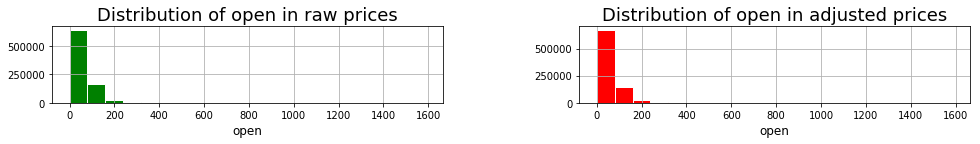

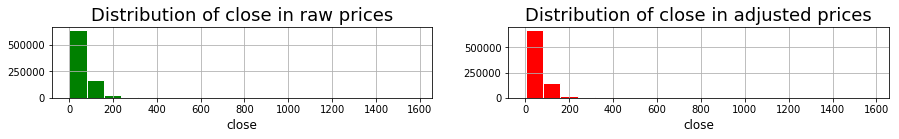

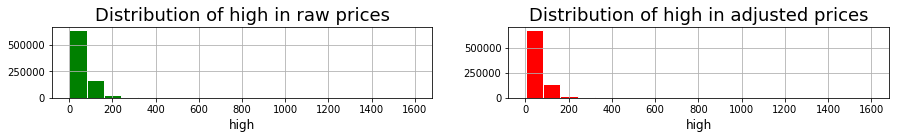

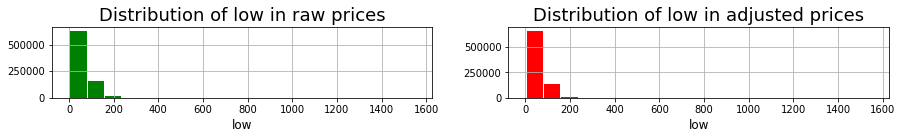

In [19]:
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
#Open
plt.subplot(4,2,1)
price_df['open'].hist(bins=20,figsize=(15,6),edgecolor='white', color='g')
#plt.plot(price_df['date'],price_df['open'])
plt.xlabel('open',fontsize=12)
plt.title('Distribution of open in raw prices',fontsize=18)

plt.subplot(4,2,2)
price_adjust_df['open'].hist(bins=20,figsize=(15,6),edgecolor='white', color='r')
#plt.plot(price_adjust_df['date'],price_adjust_df['open'])
plt.xlabel('open',fontsize=12)
plt.title('Distribution of open in adjusted prices',fontsize=18)

plt.show()

#Close
plt.subplot(4,2,3)
price_df['close'].hist(bins=20,figsize=(15,6),edgecolor='white', color='g')
plt.xlabel('close',fontsize=12)
plt.title('Distribution of close in raw prices',fontsize=18)

plt.subplot(4,2,4)
price_adjust_df['close'].hist(bins=20,figsize=(15,6),edgecolor='white', color='r')
plt.xlabel('close',fontsize=12)
plt.title('Distribution of close in adjusted prices',fontsize=18)

plt.show()
#High
plt.subplot(4,2,5)
price_df['high'].hist(bins=20,figsize=(15,6),edgecolor='white', color='g')
plt.xlabel('high',fontsize=12)
plt.title('Distribution of high in raw prices',fontsize=18)

plt.subplot(4,2,6)
price_adjust_df['high'].hist(bins=20,figsize=(15,6),edgecolor='white', color='r')
plt.xlabel('high',fontsize=12)
plt.title('Distribution of high in adjusted prices',fontsize=18)
plt.show()
#Low
plt.subplot(4,2,7)
price_df['low'].hist(bins=20,figsize=(15,6),edgecolor='white', color='g')
plt.xlabel('low',fontsize=12)
plt.title('Distribution of low in raw prices',fontsize=18)

plt.subplot(4,2,8)
price_adjust_df['low'].hist(bins=20,figsize=(15,6),edgecolor='white', color='r')
plt.xlabel('low',fontsize=12)
plt.title('Distribution of low in adjusted prices',fontsize=18)

plt.show()

In [20]:
#price_adjust_df.hist(figsize=(15,15))
#plt.rcParams['figure.figsize'] = (30,6)
#plt.plot('date','open',data=price_df)

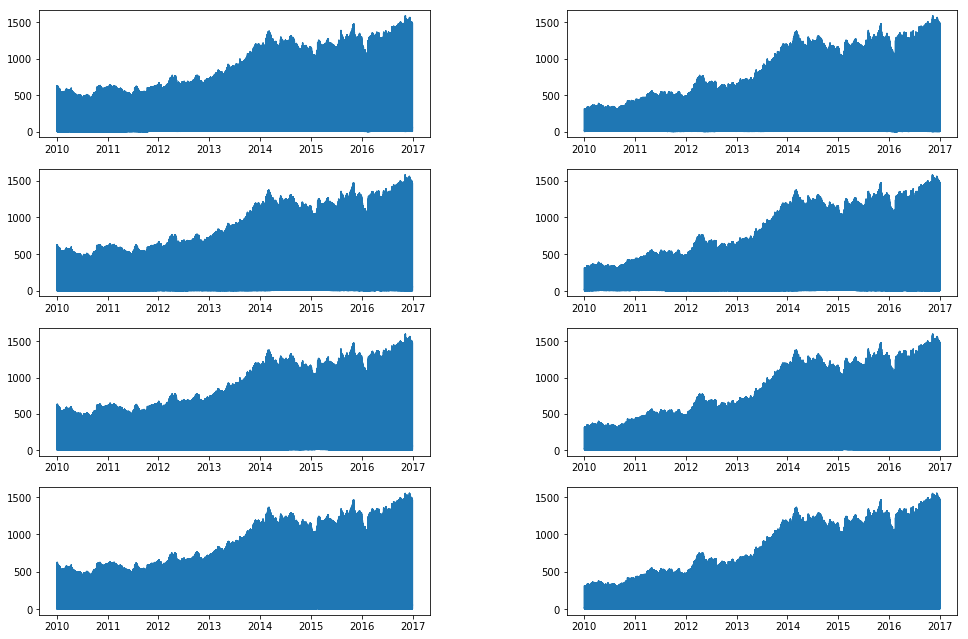

In [21]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
axes[0,0].plot('date','open',data=price_df)
#axes[0,0].set_title('Raw Open Price')
axes[0,1].plot('date','open',data=price_adjust_df)
#axes[0,1].set_title('Adjusted Open Price')
axes[1,0].plot('date','close',data=price_df)
#axes[1,0].set_title('Raw close Price')
axes[1,1].plot('date','close',data=price_adjust_df)
#axes[1,1].set_title('Adjusted close Price')
axes[2,0].plot('date','high',data=price_df)
#axes[2,0].set_title('Raw high Price')
axes[2,1].plot('date','high',data=price_adjust_df)
#axes[2,1].set_title('Adjusted high Price')
axes[3,0].plot('date','low',data=price_df)
#axes[3,0].set_title('Raw low Price')
axes[3,1].plot('date','low',data=price_adjust_df)
#axes[3,1].set_title('Adjusted low Price')

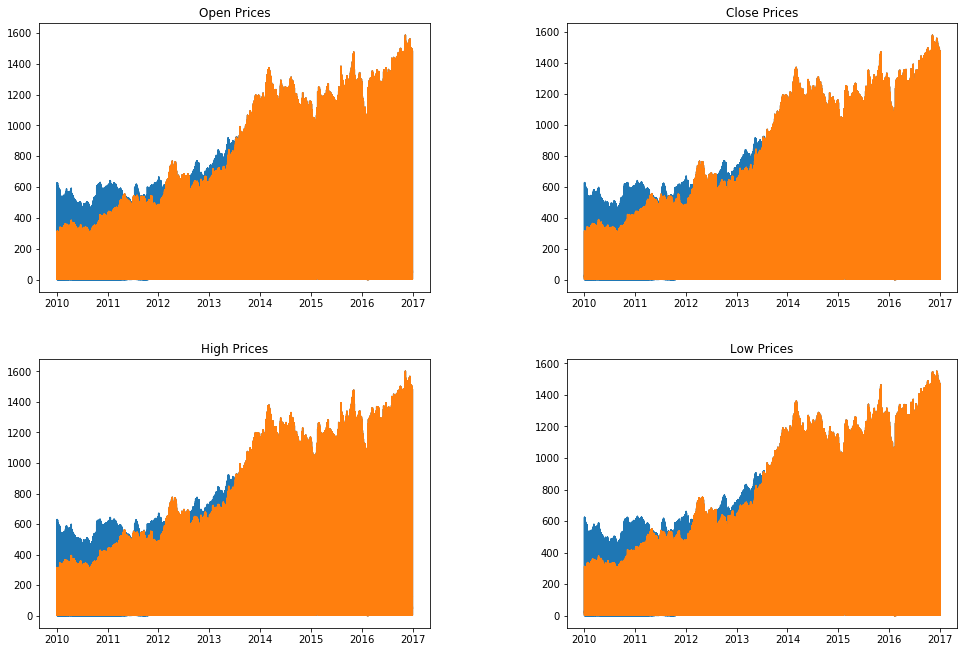

In [22]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
axes[0,0].set_title('Open Prices')
axes[0,0].plot('date','open',data=price_df)
axes[0,0].plot('date','open',data=price_adjust_df)
axes[0,1].set_title('Close Prices')
axes[0,1].plot('date','close',data=price_df)
axes[0,1].plot('date','close',data=price_adjust_df)
axes[1,0].set_title('High Prices')
axes[1,0].plot('date','high',data=price_df)
axes[1,0].plot('date','high',data=price_adjust_df)
axes[1,1].set_title('Low Prices')
axes[1,1].plot('date','low',data=price_df)
axes[1,1].plot('date','low',data=price_adjust_df)

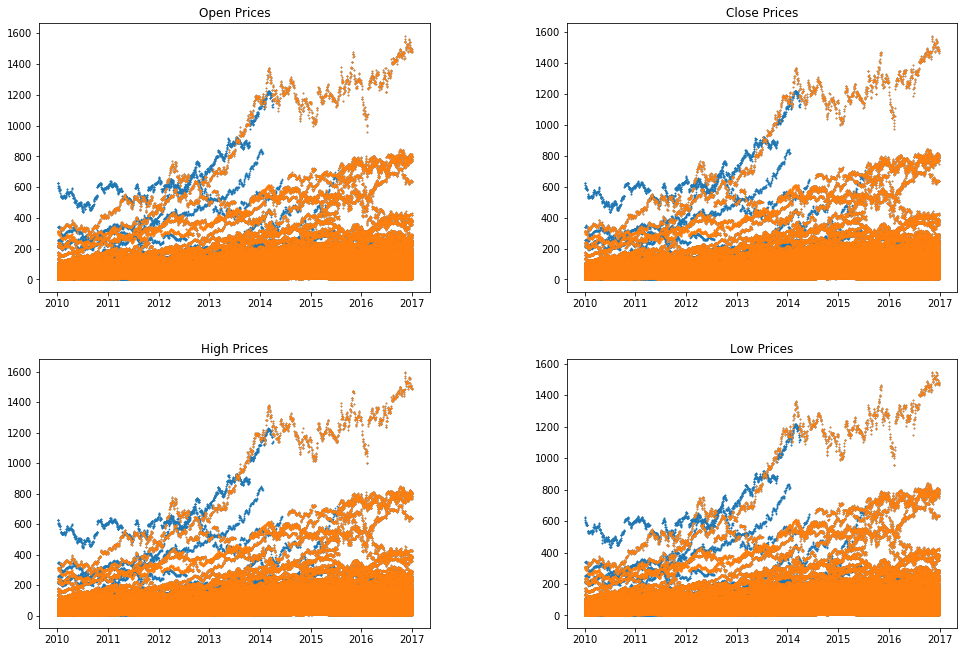

In [23]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
axes[0,0].set_title('Open Prices')
axes[0,0].scatter('date','open',data=price_df,s=0.5)
axes[0,0].scatter('date','open',data=price_adjust_df,s=0.5)
axes[0,1].set_title('Close Prices')
axes[0,1].scatter('date','close',data=price_df,s=0.5)
axes[0,1].scatter('date','close',data=price_adjust_df,s=0.5)
axes[1,0].set_title('High Prices')
axes[1,0].scatter('date','high',data=price_df,s=0.5)
axes[1,0].scatter('date','high',data=price_adjust_df,s=0.5)
axes[1,1].set_title('Low Prices')
axes[1,1].scatter('date','low',data=price_df,s=0.5)
axes[1,1].scatter('date','low',data=price_adjust_df,s=0.5)

## Result of Analysis to Consider Appropriate Prices 

After Compairing raw prices and adjusted_split prices above, you can see that 
they don't have any null values, 
they have same number of rows and columns, 
By checking the description of both datasets, 
they have different mean, standard deviation, median and the range of adjsted_split_prices is larger than the raw prices. 

By checking Histograms we can see that both are rightly skewed. 
By checking scatterplots we can see that both don't have the outliers. 

### Hence, we conclude that using larger range of values will always help to find the accurate result. 


In [24]:
price_adjust_df.head()

date symbol        open       close         low        high     volume
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
3 2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
4 2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002  1408600.0

In [25]:
price_adjust_df = price_adjust_df.rename(columns={'symbol':'company'})
price_adjust_df.head()

date company        open       close         low        high  \
0 2016-01-05    WLTW  123.430000  125.839996  122.309998  126.250000   
1 2016-01-06    WLTW  125.239998  119.980003  119.940002  125.540001   
2 2016-01-07    WLTW  116.379997  114.949997  114.930000  119.739998   
3 2016-01-08    WLTW  115.480003  116.620003  113.500000  117.440002   
4 2016-01-11    WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0

open     close       low      high    volume
open    1.000000  0.999845  0.999914  0.999928 -0.132526
close   0.999845  1.000000  0.999926  0.999925 -0.132675
low     0.999914  0.999926  1.000000  0.999889 -0.133087
high    0.999928  0.999925  0.999889  1.000000 -0.132168
volume -0.132526 -0.132675 -0.133087 -0.132168  1.000000

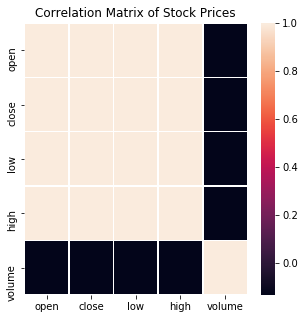

In [26]:
corr = price_adjust_df.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,linewidths=.5)
plt.title('Correlation Matrix of Stock Prices')
corr

In [27]:
price_date_indx=price_adjust_df.set_index(['date'])
price_date_indx.head()

company        open       close         low        high     volume
date                                                                         
2016-01-05    WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
2016-01-06    WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2016-01-07    WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
2016-01-08    WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
2016-01-11    WLTW  117.010002  114.970001  114.089996  117.330002  1408600.0

In [28]:
price_cmp_grp = price_date_indx.groupby(['company'])
price_cmp_grp.head()

company        open       close         low        high  \
date                                                                 
2016-01-05    WLTW  123.430000  125.839996  122.309998  126.250000   
2016-01-06    WLTW  125.239998  119.980003  119.940002  125.540001   
2016-01-07    WLTW  116.379997  114.949997  114.930000  119.739998   
2016-01-08    WLTW  115.480003  116.620003  113.500000  117.440002   
2016-01-11    WLTW  117.010002  114.970001  114.089996  117.330002   
2010-01-04       A   22.453504   22.389128   22.267525   22.625180   
2010-01-04     AAL    4.840000    4.770000    4.660000    4.940000   
2010-01-04     AAP   40.700001   40.380001   40.360001   41.040001   
2010-01-04    AAPL   30.490000   30.572857   30.340000   30.642857   
2010-01-04     ABC   26.290001   26.629999   26.139999   26.690001   
2010-01-04     ABT   26.000339   26.129884   25.870792   26.177866   
2010-01-04     ACN   41.520000   42.070000   41.500000   42.200001   
2010-01-04    ADBE   36.650002   37.090000   36.650002   37.299999   
2010-01-04     ADI   31.790001   31.670000   31.610001   32.189999   
2010-01-04     ADM   31.480000   31.469999   31.330000   31.840000   
2010-01-04     ADP   38.226514   37.603162   37.489027   38.226514   
2010-01-04     ADS   65.000000   65.889999   64.959999   66.000000   
2010-01-04    ADSK   25.610001   25.670000   25.610001   25.830000   
2010-01-04     AEE   28.030001   27.760000   27.690001   28.270000   
2010-01-04     AEP   35.099998   34.939999   34.799999   36.000000   
2010-01-04     AES   13.380000   13.670000   13.380000   13.700000   
2010-01-04     AET   32.060001   33.000000   31.870001   33.080002   
2010-01-04     AFL   46.500000   47.570000   46.500000   47.700001   
2010-01-04     AGN   39.700001   40.290001   39.700001   40.459999   
2010-01-04     AIG   30.530001   29.889999   29.410000   30.540001   
2010-01-04     AIZ   29.700001   30.160000   29.610001   30.209999   
2010-01-04     AJG   22.600000   22.330000   22.280001   22.809999   
2010-01-04    AKAM   25.629999   25.920000   25.530001   26.059999   
2010-01-04     ALB   36.910000   38.090000   36.900002   38.240002   
2010-01-04     ALK    8.705000    8.717500    8.600001    8.820000   
...            ...         ...         ...         ...         ...   
2015-06-24     WRK   63.450001   63.380001   63.380001   63.450001   
2015-06-25     WRK   62.900002   61.900002   61.900002   62.900002   
2015-06-26     WRK   61.900002   61.900002   61.900002   61.900002   
2015-06-29     WRK   60.919998   60.799999   60.799999   60.919998   
2015-06-30     WRK   61.330002   60.900002   60.330002   61.400002   
2015-07-06     KHC   71.000000   72.959999   71.000000   74.290001   
2015-07-06    PYPL   38.000000   36.709999   36.000000   39.750000   
2015-07-07     KHC   73.730003   74.629997   72.959999   74.709999   
2015-07-07    PYPL   37.720001   36.619999   36.000000   37.810001   
2015-07-08     KHC   74.300003   75.400002   74.040001   75.500000   
2015-07-08    PYPL   36.340000   34.700001   34.529999   36.360001   
2015-07-09     KHC   76.470001   74.800003   74.500000   77.066002   
2015-07-09    PYPL   35.099998   34.500000   33.990002   35.520000   
2015-07-10     KHC   75.050003   77.309998   75.000000   77.800003   
2015-07-10    PYPL   34.660000   34.689999   33.980000   35.189999   
2015-10-19     HPE   18.500000   16.549999   16.480000   18.500000   
2015-10-20     HPE   16.250000   16.870001   16.250000   16.930000   
2015-10-21     HPE   17.250000   16.480000   16.400000   17.350000   
2015-10-22     HPE   16.709999   16.950001   16.240000   17.049999   
2015-10-23     HPE   17.250000   17.000000   16.850000   17.250000   
2015-11-16    CSRA   30.500000   31.900000   30.500000   32.900002   
2015-11-17    CSRA   32.189999   32.974998   32.189999   33.439999   
2015-11-18    CSRA   33.000000   33.020000   33.000000   33.279999   
2015-11-19    CSRA   33.189999   32.500000   32.500000   33.189999   
2015-11-20    CSRA   

In [29]:
print(sorted(price_date_indx['company'].unique()))
print("\nNumber of Companies: ",price_date_indx['company'].nunique())

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX', 'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK', 'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DLTR', 'DNB', 'DOV', 'DOW', 'DPS', 

## Considering one company at a time

In [30]:
Apple_Stock= price_date_indx[price_date_indx['company']=='AAPL']
Apple_Stock.head()

company       open      close        low       high       volume
date                                                                       
2010-01-04    AAPL  30.490000  30.572857  30.340000  30.642857  123432400.0
2010-01-05    AAPL  30.657143  30.625713  30.464285  30.798571  150476200.0
2010-01-06    AAPL  30.625713  30.138571  30.107143  30.747143  138040000.0
2010-01-07    AAPL  30.250000  30.082857  29.864286  30.285715  119282800.0
2010-01-08    AAPL  30.042856  30.282858  29.865715  30.285715  111902700.0

In [31]:
Apple_Stock.drop(['company'],axis=1,inplace=True)
Apple_Stock.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



open      close        low       high       volume
date                                                               
2010-01-04  30.490000  30.572857  30.340000  30.642857  123432400.0
2010-01-05  30.657143  30.625713  30.464285  30.798571  150476200.0
2010-01-06  30.625713  30.138571  30.107143  30.747143  138040000.0
2010-01-07  30.250000  30.082857  29.864286  30.285715  119282800.0
2010-01-08  30.042856  30.282858  29.865715  30.285715  111902700.0

In [32]:
Apple_Stock.shape

(1762, 5)

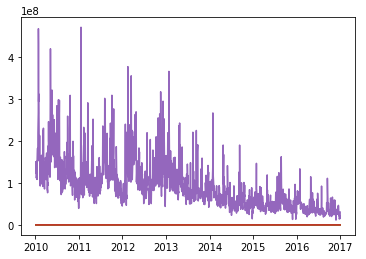

In [33]:
plt.plot(Apple_Stock)

## Checking for Trends and Seasonality

In [34]:
def test_stationary(timeseries):
    plt.figure(figsize=(25,10))
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean,color='red',label='Mean')
    plt.plot(rolstd,color='black',label='Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

def ADF_Test(timeseries):
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

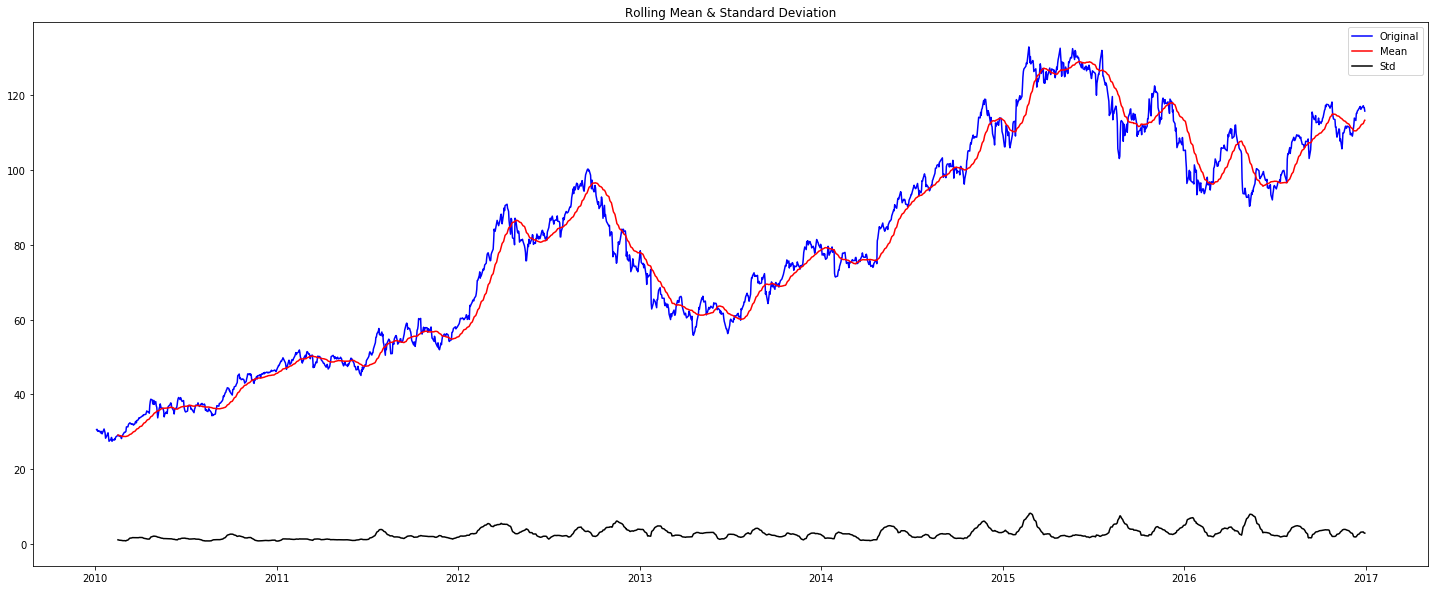

Test Statistic                   -1.324458
p-value                           0.617910
#Lags Used                        0.000000
Number of Observations Used    1761.000000
Critical Value (1%)              -3.434069
Critical Value (5%)              -2.863183
Critical Value (10%)             -2.567645
dtype: float64


In [35]:
test_stationary(Apple_Stock['close'])
ADF_Test(Apple_Stock['close'])

##### ADF Statistics:
The more negative this statistic, the more likely we are to reject the null hypothesis (We have non-stationary dataset). Here we can reject the null hypothesis with significance level of less than 1%. 
##### p-value: 
if the p-value > 0.5 then we fail to reject the null hypothesis(H0), the data has a unit root and the data is non-stationary.

###### Conclusion
In Above result,The ADF Statistic value is larger than 10% of critical value. So, we fail to reject the null hypothesis. Hence the data is <b>non-stationary</b>. 

In [36]:
Apple_Stock.head()

open      close        low       high       volume
date                                                               
2010-01-04  30.490000  30.572857  30.340000  30.642857  123432400.0
2010-01-05  30.657143  30.625713  30.464285  30.798571  150476200.0
2010-01-06  30.625713  30.138571  30.107143  30.747143  138040000.0
2010-01-07  30.250000  30.082857  29.864286  30.285715  119282800.0
2010-01-08  30.042856  30.282858  29.865715  30.285715  111902700.0

In [37]:
Apple_Stock.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='date', length=1762, freq=None)

In [38]:
decomposition = seasonal_decompose(Apple_Stock['close'],freq=365)
print(Apple_Stock['close'].index.shape)
print(decomposition.trend.shape)
dt = pd.DataFrame(Apple_Stock['close'])
dt.head()

(1762,)
(1762,)


close
date                 
2010-01-04  30.572857
2010-01-05  30.625713
2010-01-06  30.138571
2010-01-07  30.082857
2010-01-08  30.282858

In [39]:
fig = go.Figure()
trace1 = fig.add_trace(go.Scatter(x=Apple_Stock.index,y=decomposition.trend,name='Trend',mode='lines'))
trace2 = fig.add_trace(go.Scatter(x=Apple_Stock.index,y=decomposition.seasonal,name='Seasonal',mode='lines'))
trace3=fig.add_trace(go.Scatter(x=Apple_Stock.index,y=decomposition.resid,name='Residual',mode='lines'))
fig.show()

### Trend and Seasonality 

From above plot, we can easily see apple stock data is non-stationary as it has increasing trend and repitative pattern called seasonality. We know that Apple releases their new products every year in September and here in seasonality plot we can observe that every year in september the price are increasing.

### Residuals 

Residuals are difference between consecutive observations. Also, in this residual plot, you can see, there is a price jump in September 2012. 

## Removing Trend and Seasonality 

### Moving Average 

We observe that data is non-stationary(Biased). We have to remove trend and seasonality for non-biased prediction further. 
Data that we require for non-biased prediction is called as Stationary data. To make the data stationary we require a smoothing parameter called as <b>Moving Average</b>. 


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<Figure size 1800x720 with 0 Axes>

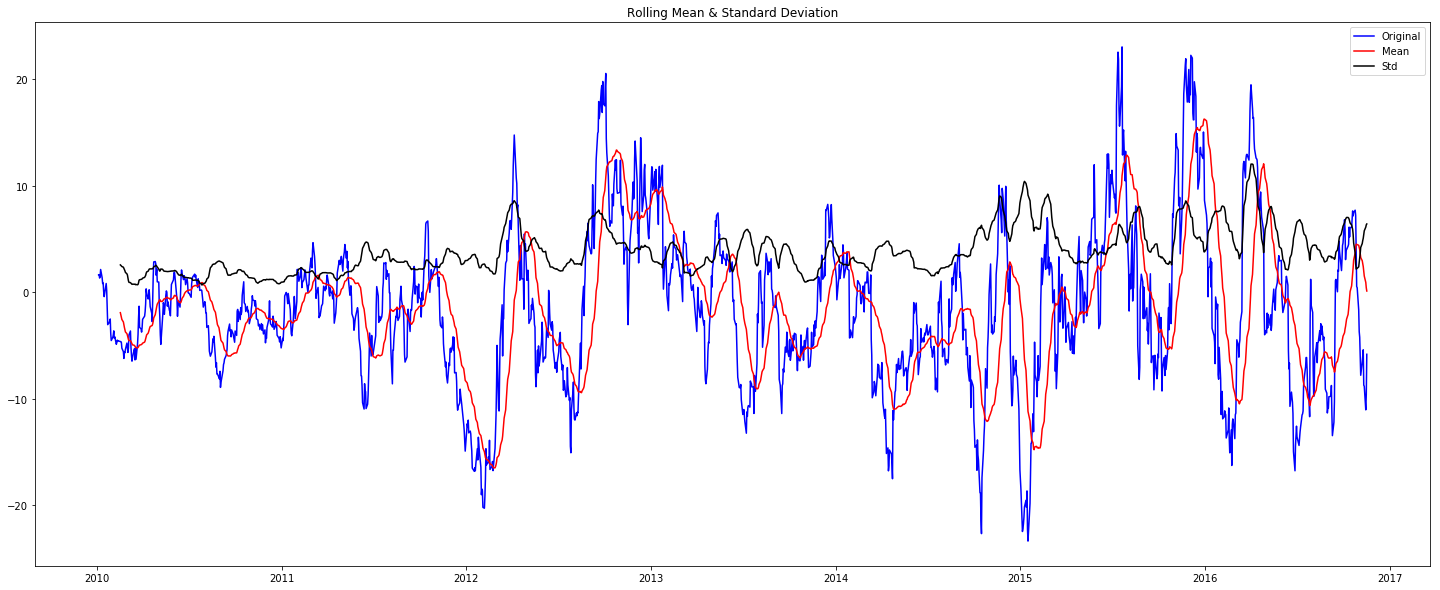

open       close         low        high      volume  Mean
date                                                                        
2016-12-23  115.589996  116.519997  115.589996  116.519997  14249500.0   NaN
2016-12-27  116.519997  117.260002  116.489998  117.800003  18296900.0   NaN
2016-12-28  117.519997  116.760002  116.199997  118.019997  20905900.0   NaN
2016-12-29  116.449997  116.730003  116.400002  117.110001  15039500.0   NaN
2016-12-30  116.650002  115.820000  115.430000  117.199997  30586300.0   NaN

In [40]:
plt.figure(figsize=(25,10))
Apple_Stock['close'].fillna(value=-99999, inplace=True)
Apple_Stock['Mean'] =  Apple_Stock['close'] - Apple_Stock['close'].shift(-30)
#Apple_Stock['Mean'].dropna(inplace=True)
test_stationary(Apple_Stock['Mean'])
Apple_Stock.tail()

In [45]:
Apple_Stock.tail()

open       close         low        high      volume  Mean
date                                                                        
2016-12-23  115.589996  116.519997  115.589996  116.519997  14249500.0   NaN
2016-12-27  116.519997  117.260002  116.489998  117.800003  18296900.0   NaN
2016-12-28  117.519997  116.760002  116.199997  118.019997  20905900.0   NaN
2016-12-29  116.449997  116.730003  116.400002  117.110001  15039500.0   NaN
2016-12-30  116.650002  115.820000  115.430000  117.199997  30586300.0   NaN

## Applying Linear Regression Algorithm using Sklearn

In [46]:
X=np.array(Apple_Stock.drop(['open','low','high','volume'],axis=1))
X = X[:-30]
X = preprocessing.scale(X)
X_lately = X[-30:]

Apple_Stock.dropna(inplace=True)

y= np.array(Apple_Stock['Mean'])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4)

print("X:",len(X))
print("Y:",len(y))


X: 1732
Y: 1732


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [47]:
clf = LinearRegression(n_jobs=-1) #use classifier as Linear Regression 
clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)
print(accuracy)

1.0


1.265677805184145e-30
Mean squared error: 0.00
Variance score: 1.00


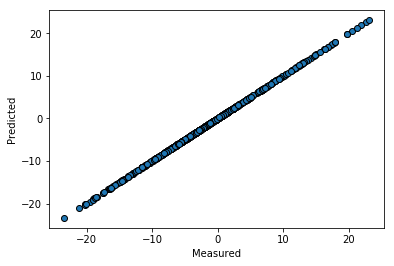

[  3.940002   4.         4.32       4.5        6.109993   5.190002
   6.059997   6.090004   6.950004   7.630005   7.159996   7.489997
   7.700005   7.220001   3.469993   0.530006   0.419998  -1.650001
  -3.700004  -4.230004  -6.139999  -7.800003  -6.539993  -6.
  -5.410004  -8.729996  -8.830002 -11.050003  -9.620002  -5.830002]


In [48]:
forecast= clf.predict(X_test)
#print(forecast)

MSE = np.mean((y_test-clf.predict(X_test)) ** 2)

print(MSE)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, forecast))


print('Variance score: %.2f' % r2_score(y_test, forecast))
                 

fig, ax = plt.subplots()
ax.scatter(y_test, forecast, edgecolors=(0, 0, 0))
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()    
    
    
forecast_set = clf.predict(X_lately)
print(forecast_set)

693
693


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Last_Date: 2014-02-20


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



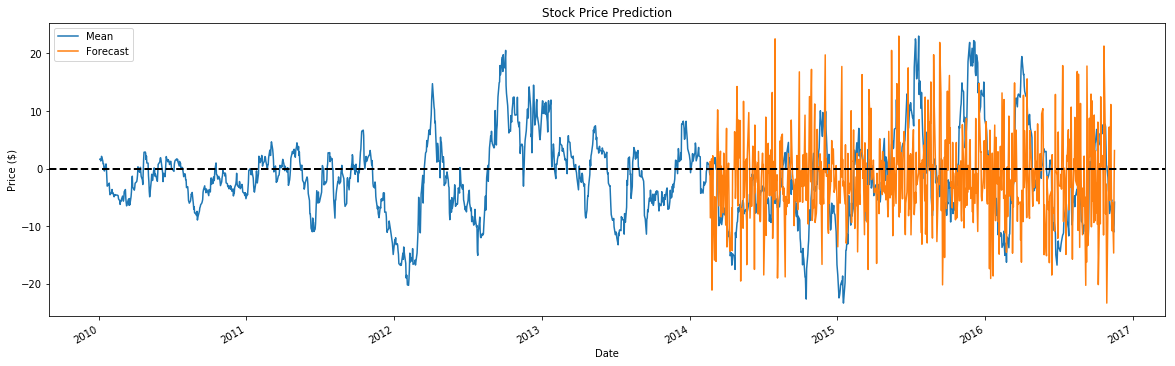

<Figure size 432x288 with 0 Axes>

In [49]:
length_x_test = len(X_test)
print(length_x_test)
print(len(forecast))
Apple_Stock['Forecast'] = np.nan

lastdate = len(Apple_Stock)-length_x_test
Apple_Stock['date1'] = Apple_Stock.index.date


last_date = Apple_Stock.iloc[lastdate].date1

        
print("Last_Date:",last_date)

for i in forecast:
    next_date = Apple_Stock.iloc[lastdate].date1
    lastdate = lastdate+1
    Apple_Stock.loc[next_date,'Forecast'] = i   
    
Apple_Stock.tail()
Apple_Stock['Mean'].plot(legend=True, figsize=(20,6))
Apple_Stock['Forecast'].plot(legend=True, figsize=(20,6))
plt.axhline(y=0,linestyle='dashed', color='black', linewidth=2)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()
plt.savefig('prediction1.png')

In [50]:
print(forecast)
print(y_test)

[ 1.19999700e+00 -8.56285857e+00  1.68999871e+00 -2.11100010e+01
 -2.49428557e+00  2.22999500e+00 -7.52143100e+00 -1.58957139e+01
 -4.89142800e+00 -1.29499969e+01 -5.54000100e+00 -1.61228600e+01
  6.09000400e+00  1.02028580e+01  6.48143014e+00  1.58428571e+00
 -6.47999600e+00  1.42000200e+00  3.01857371e+00 -8.38428500e+00
  4.19998000e-01 -1.58142857e+00 -1.18286129e+00 -7.68000000e+00
  2.68428800e+00  2.19999700e+00 -1.81285857e+00 -9.82000000e+00
  1.43714143e+00  6.98999800e+00 -1.36185684e+01 -2.21571343e+00
  9.47136000e-01 -5.38142971e+00 -1.14785690e+01 -1.41599960e+01
 -1.43699950e+01 -1.10157127e+01 -6.83570857e+00 -1.42657127e+01
 -5.57137143e-02 -5.57135714e-02  6.40856929e+00  2.15000200e+00
 -5.19000200e+00 -2.88000486e+00  1.42600020e+01  6.18142329e+00
 -6.47571171e+00  1.00020000e-02  8.45000500e+00  1.86000100e+00
  8.34571086e+00 -1.95399930e+01 -6.91143071e+00 -7.09285700e+00
 -8.83000200e+00 -1.03600010e+01  1.16899940e+01  1.08999700e+00
 -5.04000100e+00  1.30571

In [51]:
import csv
csvfile = "forecast.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in forecast:
        writer.writerow([val])

1.1999969999999966
1.1999969999999962


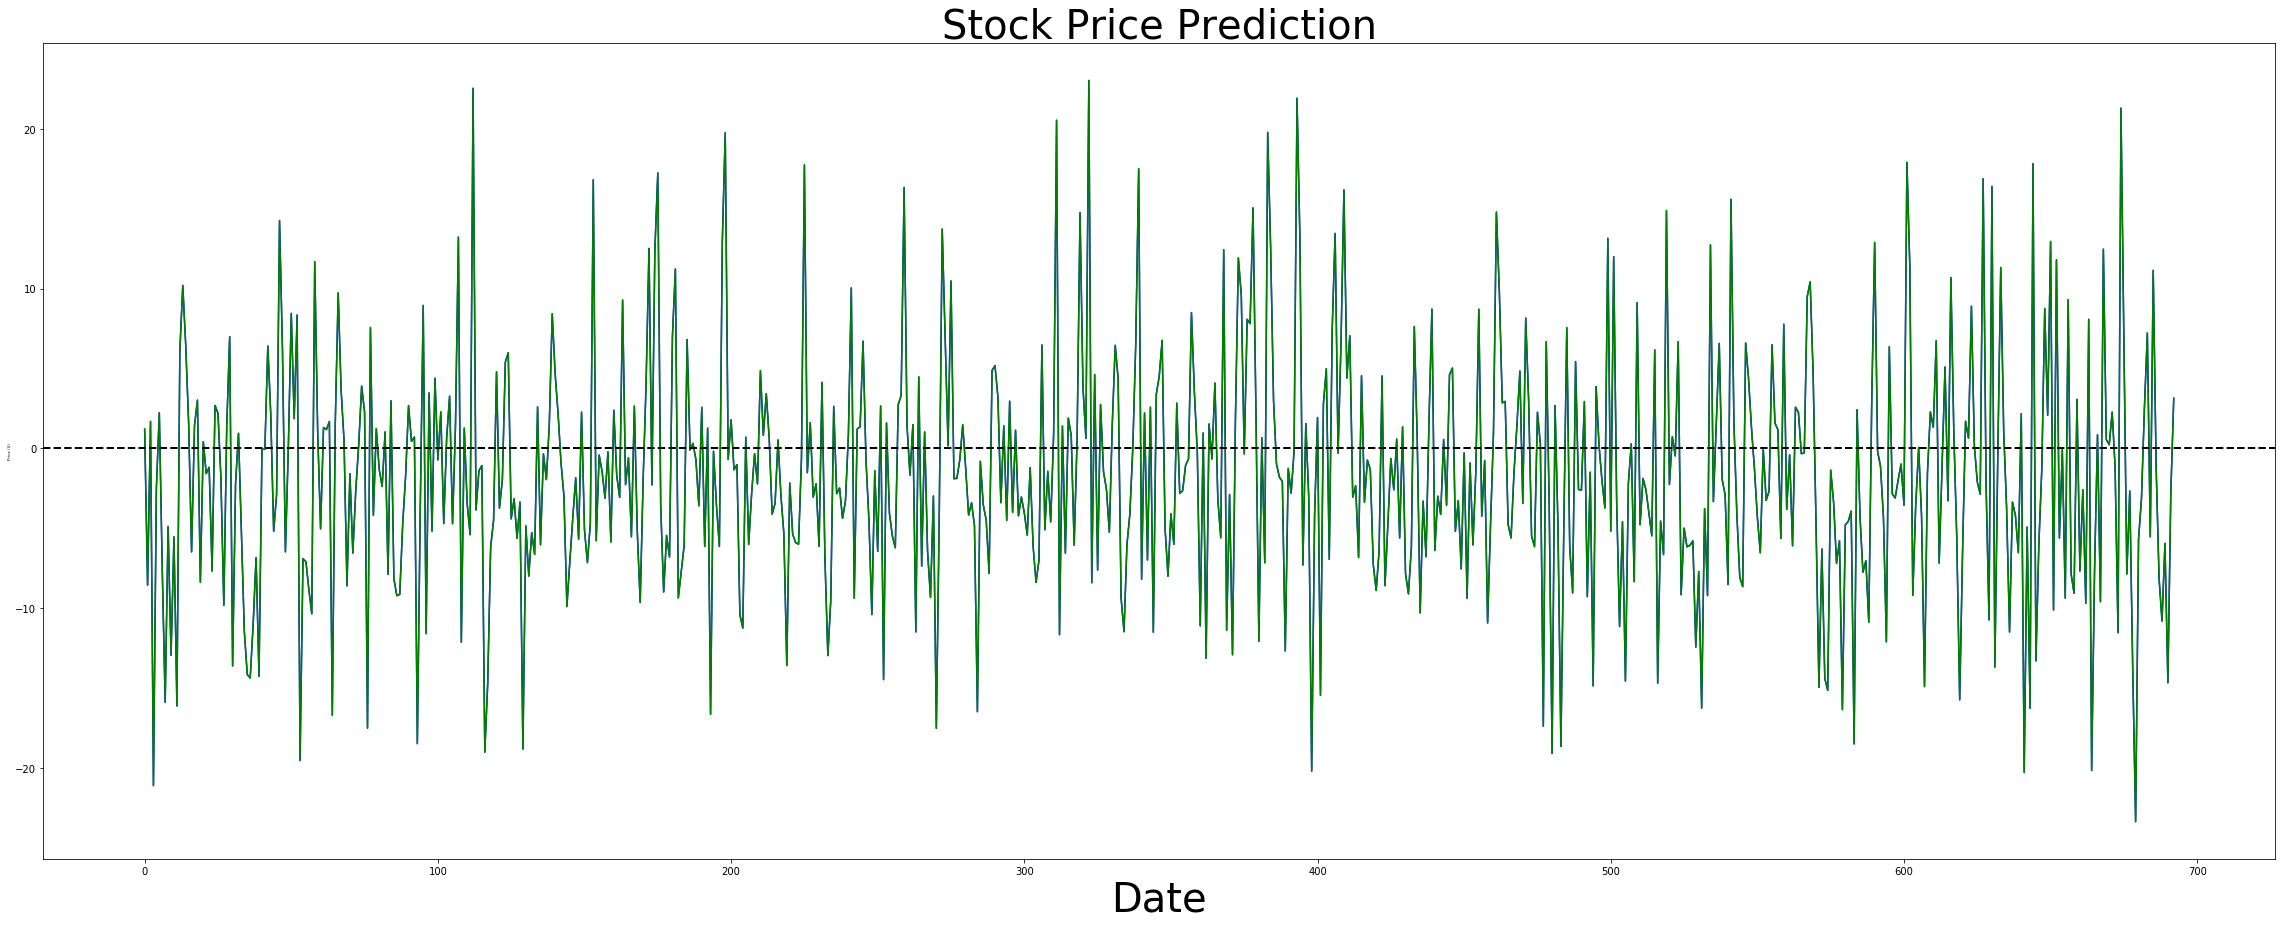

In [52]:
print(forecast[0])
print(y_test[0])
plt.figure(figsize=(40,15))
plt.plot(y_test,'b')
plt.plot(forecast,'g')
plt.axhline(y=0,linestyle='dashed', color='black', linewidth=2)
plt.title('Stock Price Prediction', fontsize=40)
plt.xlabel('Date',fontsize=40)
plt.ylabel('Price ($)',fontsize=4)
plt.show()

Text(0.5,0,'Date')

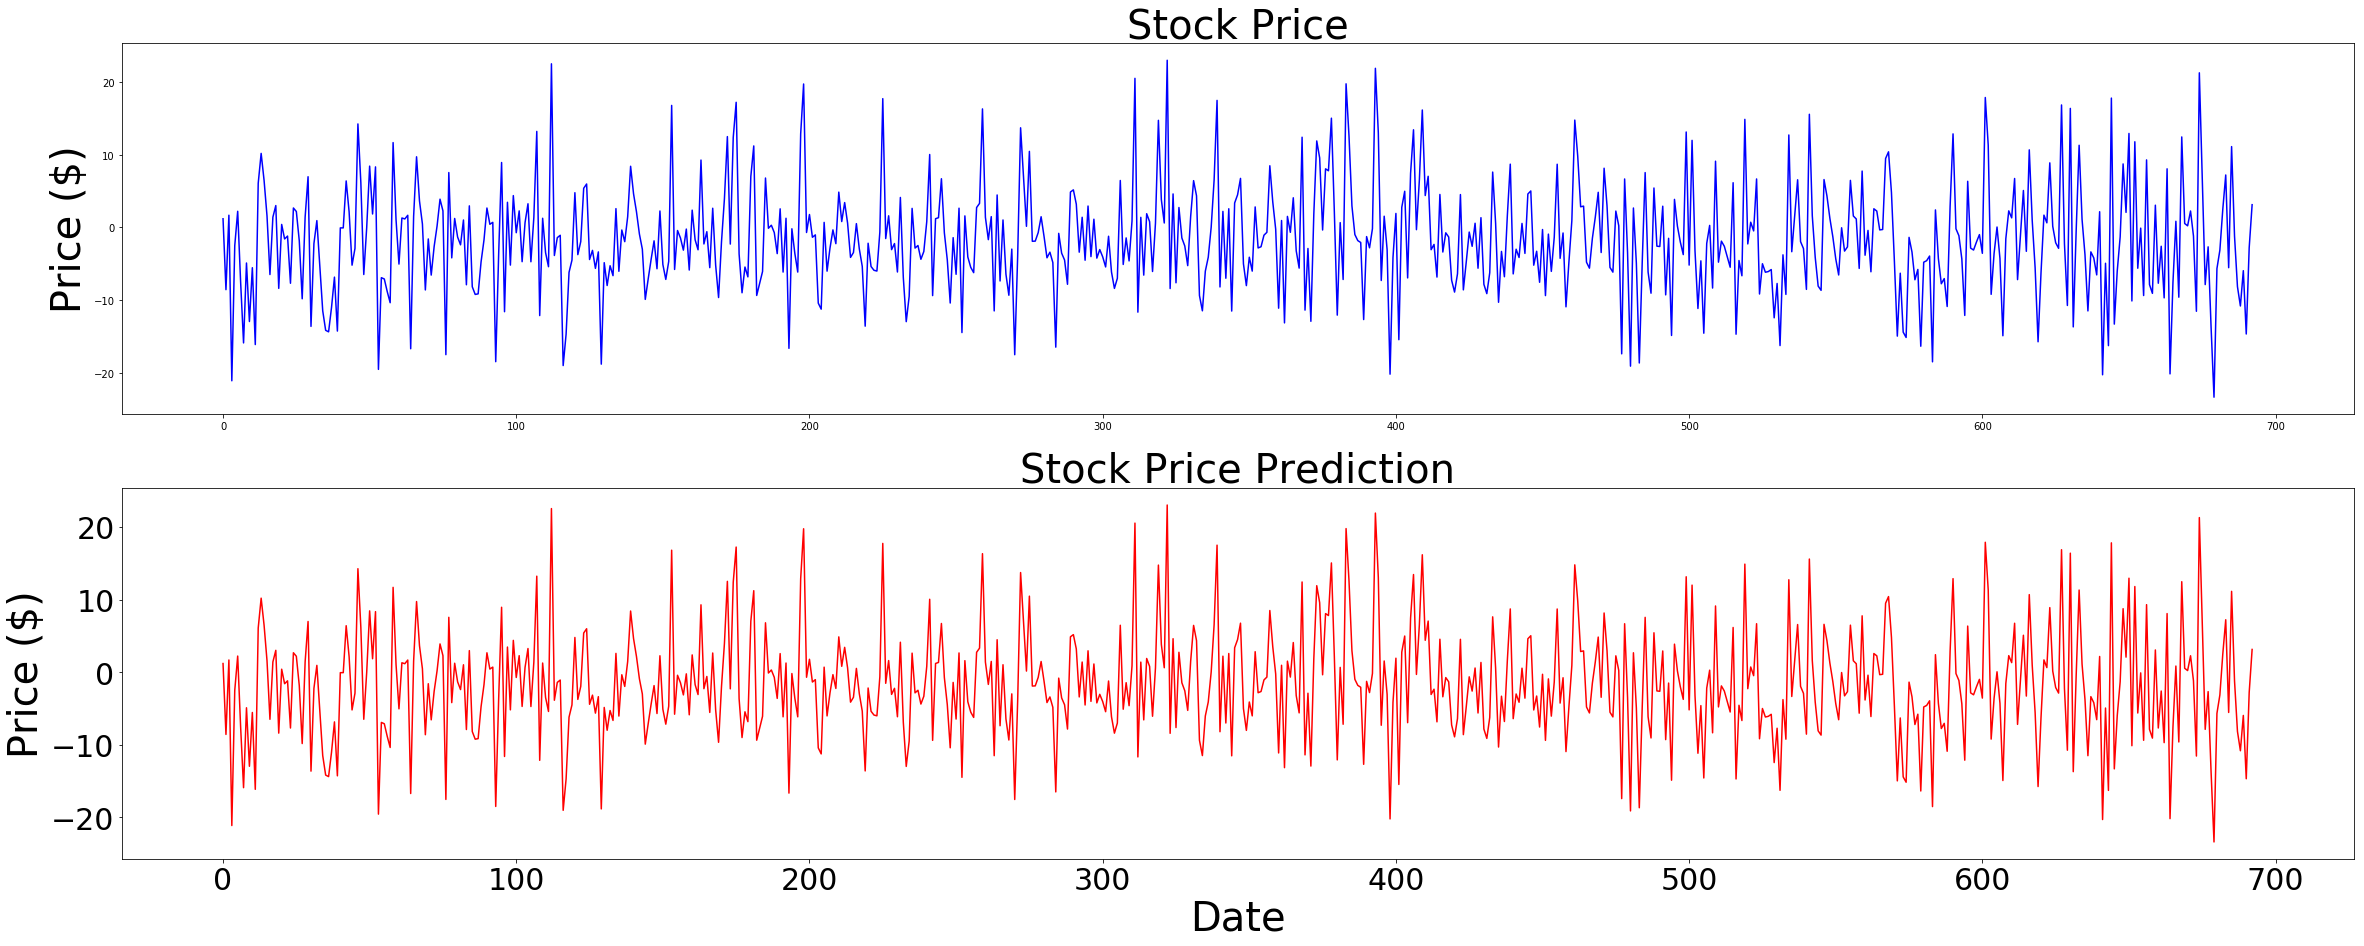

In [53]:
plt.figure(1,figsize=(40,15))                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot(y_test,'b')
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.title('Stock Price', fontsize=40)
plt.ylabel('Price ($)',fontsize=40)
plt.subplot(212)             # the second subplot in the first figure
plt.plot(forecast,'r')
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.title('Stock Price Prediction', fontsize=40)
plt.ylabel('Price ($)',fontsize=40)
plt.xlabel('Date',fontsize=40)

In [54]:
Apple_Stock.to_csv("prices_microsoft1.csv")

In [55]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, forecast))

Mean squared error: 0.00


In [56]:
print('Variance score: %.2f' % r2_score(y_test, forecast))

Variance score: 1.00
